# The Sine Curve Dataset

## Original Image

This dataset consist of an image of a sine curve, expressed as:

$$
B = 2\pi \frac{1}{T}
\\
y = A\sin{(Bx)}
$$

We set:

- The amplitude $A = 6$ $\mu$m.
- The period $T = 15$ $\mu$m.

The curvature of this sine curve can be expressed as:

$$
\label{eq:curvature-sine} \kappa = \frac{AB^2\sin(Bx)}{(1 + A^2B^2\cos^2(Bx))^{3/2}}
$$

## Dataset

We build three differents dataset. Each one contain a set of images and initialization curves that vary according to a defined parameters.

### Variable signal-to-noise (SNR) ratio

- **SNR:** from 0 to 25 dB.
- **Pixel Size:** 160 nm.
- **Intensity threshold:** 2 standard deviations above the mean image intensity.
- **Initial curve pixel inclusion:** 15 pixels.
- **Point Distance Minimization Algorithm:** enabled.
- **Control Point Adjustement:** enabled.
- **Folder name:** `variable_snr`

### Variable pixel size

- **SNR:** 40 dB.
- **Pixel Size:** from 10 to 400 nm.
- **Intensity threshold:** 2 standard deviations above the mean image intensity.
- **Initial curve pixel inclusion:** 15 pixels.
- **Point Distance Minimization Algorithm:** enabled.
- **Control Point Adjustement:** enabled.
- **Folder name:** `variable_pixel_size`

### Variable initial position

Here we add some noise to the initialization curve.

- **SNR:** 20 dB.
- **Pixel Size:** 160 nm.
- **Intensity threshold:** 2 standard deviations above the mean image intensity.
- **Initial curve pixel inclusion:** 15 pixels.
- **Point Distance Minimization Algorithm:** enabled.
- **Control Point Adjustement:** enabled.
- **Folder name:** `variable_initial_position`

---

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tifffile
from scipy import signal
from scipy import ndimage

import sys; sys.path.append("../../")
import pykappa

data_dir = Path("/home/hadim/.data/Postdoc/Kappa/sine_curve")
data_dir.mkdir(exist_ok=True)

variable_snr_dir = data_dir / "variable_snr"
variable_pixel_size_dir = data_dir / "variable_pixel_size"
variable_initial_position_dir = data_dir / "variable_initial_position"
variable_psf_size_dir = data_dir / "variable_psf_size"

theoretical_curvatures_fname = "Original_Curve.csv"
original_curve_fname = "Original_Curve.tif"
original_curve_non_convoluted_fname = "Original_Curve_Non_Convoluted.tif"

# We use a small pixel size for the 
# original image that will be used 
# to build all the different dataset.
original_pixel_size = 0.01  # um

# We choose the image width to correspond the 
# desired period of the sine curve of 15 um
im_size = 1500  # pixel

signal_value = 100

fixed_snr = 20  # dB
fixed_pixel_size = 0.16  # um/pixel

## Build the original image

This original image will be used to build all the dataset.

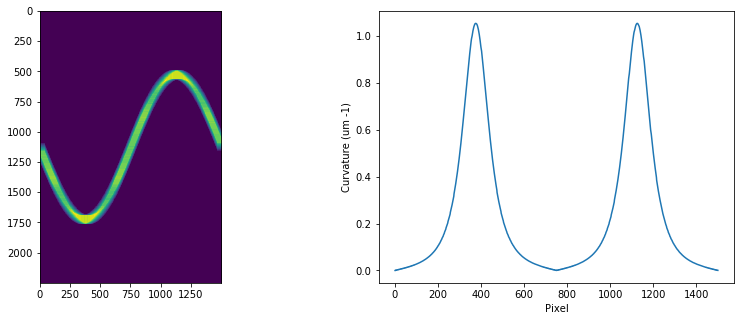

In [2]:
# Generate blank image
image_size = (int(im_size * 1.5), im_size)
im = np.zeros(image_size)

# Sine curve parameters
amplitude_um = 6
period_um = 15

# Convert parameters from um to pixels
A = amplitude_um / original_pixel_size
B = 2 * np.pi / (period_um / original_pixel_size)
weight = 2

curvatures = []
x_coordinates = []
y_coordinates = []

step = 0
while step <= im_size - 1 - 0:
    x = int(np.round(step))
    y = int(np.round(A * np.sin(x * B)) + im.shape[0] / 2)
    
    x_coordinates.append(x)
    y_coordinates.append(y)
    
    im[y, x] = signal_value
    curvature_value = np.abs((A * B**2 * np.sin(B * step)) / (1 + A**2 * B**2 * (np.cos(B * step))**2)**(3 / 2))
    
    curvature = {}
    curvature["curvature (1/pixel)"] = curvature_value
    curvature["x coordinate (pixel)"] = x
    curvature["curvature (1/um)"] = curvature["curvature (1/pixel)"] / original_pixel_size
    curvature["x coordinate (um)"] = curvature["x coordinate (pixel)"] * original_pixel_size
    curvatures.append(curvature)
    
    # We use a variable step size to prevent the peaks of
    # the sine curve from becoming too bright
    dstep = 0.1 + np.abs(np.sin(B * step)) * weight
    step += dstep
    
curvatures = pd.DataFrame(curvatures)
x_coordinates = np.array(x_coordinates)  
y_coordinates = np.array(y_coordinates)  

# Save the non convoluted image
im_non_convoluted = pykappa.imaging.rescale_to_8bit(im.copy())
tifffile.imsave(str(data_dir / original_curve_non_convoluted_fname), im_non_convoluted)
    
# Convolution with a gaussian with a sigma of 300 nm (0.3 um)
# corresponds with a wavelength of 530 nm.
sigma = 0.3 / original_pixel_size
kernel = pykappa.imaging.gaussian_kernel(size=sigma * 2.5, sigma=sigma)
im = signal.convolve2d(im, kernel, mode="same")

# Save the convolved image
im = pykappa.imaging.rescale_to_8bit(im)
tifffile.imsave(str(data_dir / original_curve_fname), im)

# Save curvature data
curvatures.to_csv(data_dir / theoretical_curvatures_fname)

# Plot original image and associated curvature
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
ax1.imshow(im, interpolation='none', aspect='equal')
ax2.plot(curvatures["x coordinate (pixel)"], curvatures["curvature (1/um)"])
ax2.set_xlabel("Pixel")
ax2.set_ylabel("Curvature (um -1)")
fig.savefig((data_dir / theoretical_curvatures_fname).with_suffix('.png'))

### Plot Image Generation Process

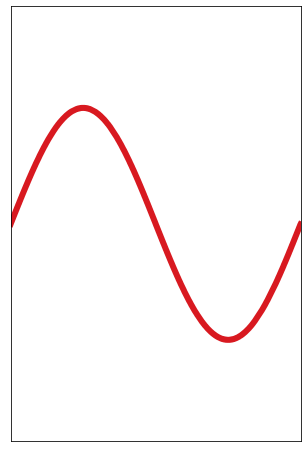

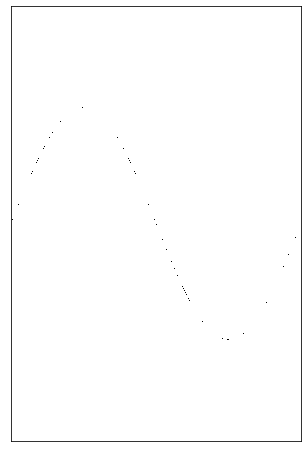

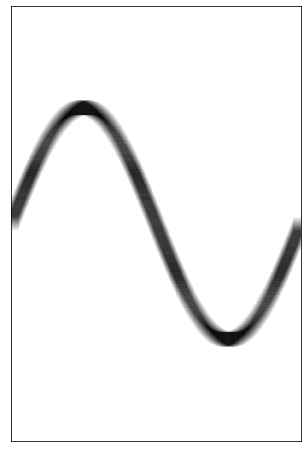

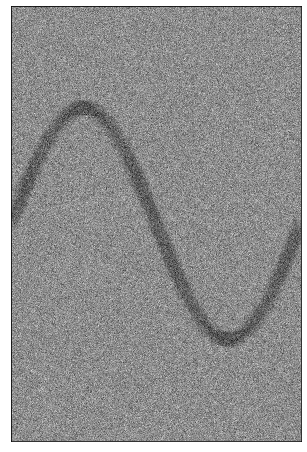

In [3]:
generation_dir = data_dir / "image_generation_process"
generation_dir.mkdir(exist_ok=True)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.plot(x_coordinates, y_coordinates, lw=6, color="#d81920ff")
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "1_coordinates.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.imshow(np.invert(im_non_convoluted), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "2_discretization.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
ax.imshow(np.invert(im), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "3_convolution.png", dpi=300, bbox_inches='tight',transparent=False)

base_size = 8
fig, ax = plt.subplots(figsize=(base_size, base_size), frameon=False)
im_noise = pykappa.imaging.awgn(im, 12 * 3)
im_noise = pykappa.imaging.rescale_to_8bit(im_noise)
ax.imshow(np.invert(im_noise), cmap='gray')
ax.set_xlim(0, image_size[1])
ax.set_ylim(0, image_size[0])
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
fig.savefig(generation_dir / "4_noise.png", bbox_inches='tight',transparent=False)

### Build the "Variable SNR" dataset

In [4]:
# Generates images with differing signal to noise ratios.
# Lowers image intensity too.

variable_snr_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

snr_range = np.arange(0, 26, 1)  # dB
n = len(snr_range)

scale_factor = original_pixel_size / fixed_pixel_size

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()
curves = pykappa.io.transform_positions(original_curves.copy(), lambda x: x * scale_factor)

for snr in tqdm(snr_range, total=n):
    
    # Apply scale factor
    im = ndimage.zoom(original_image, scale_factor, order=1)
    
    # Adjust SNR
    im = pykappa.imaging.awgn(im, snr)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_snr_dir / f"snr_{snr:02}_dB.tif"
    tifffile.imsave(str(fname), im)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)

/home/hadim/local/conda/envs/kappa/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


### Build the "Variable Pixel Size" dataset

In [5]:
# Generates images with reduced effective pixel size by scaling.
# Rescaling is done with bilinear interpolation.

variable_pixel_size_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

pixel_size_range = np.arange(0.01, 0.41, 0.02)  # um/pixel
n = len(pixel_size_range)

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()

for pixel_size in tqdm(pixel_size_range, total=n):
    
    # Compute the desired scale factor
    scale_factor = original_pixel_size / pixel_size
    
    im = original_image.copy()
    
    # Adjust SNR
    im = pykappa.imaging.awgn(im, 40)
    
    # Apply the scale factor to the original image
    im = ndimage.zoom(im, scale_factor, order=1)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_pixel_size_dir / f"pixel_size_{pixel_size:0.2f}_um.tif"
    tifffile.imsave(str(fname), im)
    
    # Scale initialization curves
    curves = pykappa.io.transform_positions(original_curves, lambda x: x * scale_factor)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)

### Build the "Variable Initial Curve" dataset

In [6]:
# Copy the same image with different name. They will
# be fitted with different initial curves.

variable_initial_position_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_fname))

initial_position_noise_range = np.arange(0.1, 1.4, 0.1)  # um
n = len(initial_position_noise_range)

# Compute image
im = ndimage.zoom(original_image, original_pixel_size / fixed_pixel_size, order=1)
im = pykappa.imaging.awgn(im, fixed_snr)
im = pykappa.imaging.rescale_to_8bit(im)

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()
scale_factor = original_pixel_size / fixed_pixel_size
original_curves = pykappa.io.transform_positions(original_curves, lambda x: x * scale_factor)

# Function to add some noise to init curves
def add_noise(pos, noise_pixel):
    if noise_pixel > 0:
        pos += np.random.normal(loc=0, scale=noise_pixel, size=pos.shape)
    return pos

for initial_position_noise in tqdm(initial_position_noise_range, total=n):
    
    # Save image as TIF
    fname = variable_initial_position_dir / f"initial_position_noise_{initial_position_noise:0.2f}_au.tif"
    tifffile.imsave(fname, im)
    
    # Add noise to initialization curves
    noise_pixel = initial_position_noise / fixed_pixel_size
    noisy_curves = pykappa.io.transform_positions(original_curves, lambda pos: add_noise(pos, noise_pixel))
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(noisy_curves, kappa_path)

### Build the "Variable PSF Size" dataset

In [ ]:
# Generates images with different PSF size.
# No noise added to the image.

variable_psf_size_dir.mkdir(exist_ok=True)
original_image = tifffile.imread(str(data_dir / original_curve_non_convoluted_fname))

psf_size_range = [0, 0.05, 0.2, 0.3, 0.6, 0.8, 1.0]  # um
n = len(psf_size_range)

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()

# # Compute the desired scale factor
# pixel_size = 0.04
# scale_factor = original_pixel_size / pixel_size
pixel_size = original_pixel_size

# Compute initialization curves
original_curves = pykappa.data.get_sine_curves()
# curves = pykappa.io.transform_positions(original_curves.copy(), lambda x: x * scale_factor)
curves = original_curves

for psf_size in tqdm(psf_size_range, total=n):

    im = original_image.copy()
    
    # Convolve the image
    if psf_size > 0:
        sigma = psf_size / pixel_size
        kernel = pykappa.imaging.gaussian_kernel(size=sigma * 2.5, sigma=sigma)
        im = signal.convolve2d(im, kernel, mode="same")
    
#     # Apply the scale factor to the convolved image
#     im = ndimage.zoom(im, scale_factor, order=1)
    
    # Rescale to 8 bits
    im = pykappa.imaging.rescale_to_8bit(im)
    
    # Save image as TIF
    fname = variable_psf_size_dir / f"psf_size_{psf_size:0.2f}_um.tif"
    tifffile.imsave(str(fname), im)
    
    # Save initialization curves
    kappa_path = fname.with_suffix(".kapp")
    pykappa.io.write_kappa(curves, kappa_path)

In [5]:
5 + 5

10